In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '66-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-00a03a913a177ffd710f19e39a9e65d51860d02557f57cc1d1d8e589'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image['input_image'] = data_augment_spatial(image['input_image'])
      else: # Rotate
        image['input_image'] = data_augment_rotate(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    if p_spatial2 >= .5: 
      if p_spatial2 >= .75: # Shift
        image['input_image'] = data_augment_shift(image['input_image'])
      else: # Shear
        image['input_image'] = data_augment_shear(image['input_image'])
        
    if p_pixel >= .6: # Pixel-level transforms
      if p_pixel >= .9:
        image['input_image'] = data_augment_hue(image['input_image'])
      elif p_pixel >= .8:
        image['input_image'] = data_augment_saturation(image['input_image'])
      elif p_pixel >= .7:
        image['input_image'] = data_augment_contrast(image['input_image'])
      else:
        image['input_image'] = data_augment_brightness(image['input_image'])

    if p_rotation >= .5: # Rotation
      image['input_image'] = data_augment_rotation(image['input_image'])
    
    # if p_cutout >= .5: # Cutout
    #   image['input_image'] = data_augment_cutout(image['input_image'])
    
    return image, label


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_cutout(image, min_mask_size=(10, 10), max_mask_size=(80, 80)):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], min_mask_size, max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], min_mask_size, max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], min_mask_size, max_mask_size, k=1)
        
    return image

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

In [11]:
#@title
lr_min = 1e-6
# lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
# hold_max_steps = 0
# step_decay = .8
# step_size = steps_per_epoch * 1

# rng = [i for i in range(0, total_steps, 32)]
# y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
#                                warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
#                                lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]

# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            optimizer = tfa.optimizers.RectifiedAdam(lr=lr_max,
                                                     total_steps=total_steps,
                                                     warmup_proportion=(warmup_steps / total_steps),
                                                     min_lr=lr_min)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.2), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


16703488/16696600 [==============================] - 0s 0us/step
Epoch 1/12
204/204 - 38s - auc: 0.6032 - loss: 1.9243 - val_auc: 0.7112 - val_loss: 0.4696
Epoch 2/12
204/204 - 27s - auc: 0.7422 - loss: 1.0572 - val_auc: 0.8315 - val_loss: 0.4890
Epoch 3/12
204/204 - 26s - auc: 0.8177 - loss: 0.6149 - val_auc: 0.8500 - val_loss: 0.4742
Epoch 4/12
204/204 - 27s - auc: 0.8433 - loss: 0.5711 - val_auc: 0.8797 - val_loss: 0.5021
Epoch 5/12
204/204 - 25s - auc: 0.8581 - loss: 0.5639 - val_auc: 0.8767 - val_loss: 0.4364
Epoch 6/12
204/204 - 27s - auc: 0.8742 - loss: 0.5457 - val_auc: 0.8842 - val_loss: 0.4861
Epoch 7/12
204/204 - 27s - auc: 0.8979 - loss: 0.5254 - val_auc: 0.8917 - val_loss: 0.5383
Epoch 8/12
204/204 - 27s - auc: 0.8963 - loss: 0.5326 - val_auc: 0.8948 - val_loss: 0.5276
Epoch 9/12
204/204 - 24s - auc: 0.9099 - loss: 0.5129 - val_auc: 0.8930 - val_loss: 0.4781
Epoch 10/12
204/204 - 26s - auc: 0.9242 - loss: 0.4981 - val_auc: 0.9010 - val_loss: 0.4999
Epoch 11/12
204/204 - 24

INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 40s - auc: 0.5279 - loss: 1.9317 - val_auc: 0.6694 - val_loss: 0.4492
Epoch 2/12
204/204 - 27s - auc: 0.7325 - loss: 1.0961 - val_auc: 0.8579 - val_loss: 0.4725
Epoch 3/12
204/204 - 27s - auc: 0.8310 - loss: 0.5941 - val_auc: 0.8682 - val_loss: 0.4318
Epoch 4/12
204/204 - 27s - auc: 0.8513 - loss: 0.5651 - val_auc: 0.8740 - val_loss: 0.4494
Epoch 5/12
204/204 - 27s - auc: 0.8564 - loss: 0.5635 - val_auc: 0.8898 - val_loss: 0.5030
Epoch 6/12
204/204 - 27s - auc: 0.8804 - loss: 0.5431 - val_auc: 0.8979 - val_loss: 0.5529
Epoch 7/12
204/204 - 27s - auc: 0.8980 - loss: 0.5279 - val_auc: 0.8995 - val_loss: 0.5210
Epoch 8/12
204/204 - 25s - auc: 0.9047 - loss: 0.5173 - val_auc: 0.8991 - val_loss: 0.5570
Epoch 9/12
204/204 - 28s - auc: 0.9104 - loss: 0.5192 - val_auc: 0.9080 - val_loss: 0.5445
Epoch 10/12
204/204 - 25s - auc: 0.9189 - loss: 0.4941 - val_auc: 0.9080 - val_loss: 0.5029
Epoch 11/12
204/204 - 27s - auc: 0.9327 - loss: 0.4914 - val_auc: 0.9150 - val_loss: 0.50

INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - auc: 0.5434 - loss: 1.9342 - val_auc: 0.5903 - val_loss: 0.4870
Epoch 2/12
204/204 - 27s - auc: 0.7315 - loss: 1.0911 - val_auc: 0.8379 - val_loss: 0.4734
Epoch 3/12
204/204 - 25s - auc: 0.8368 - loss: 0.5959 - val_auc: 0.8340 - val_loss: 0.4811
Epoch 4/12
204/204 - 27s - auc: 0.8551 - loss: 0.5596 - val_auc: 0.8673 - val_loss: 0.5177
Epoch 5/12
204/204 - 27s - auc: 0.8575 - loss: 0.5671 - val_auc: 0.8709 - val_loss: 0.4953
Epoch 6/12
204/204 - 28s - auc: 0.8770 - loss: 0.5435 - val_auc: 0.8748 - val_loss: 0.5597
Epoch 7/12
204/204 - 27s - auc: 0.8902 - loss: 0.5290 - val_auc: 0.8879 - val_loss: 0.5203
Epoch 8/12
204/204 - 28s - auc: 0.8897 - loss: 0.5331 - val_auc: 0.8971 - val_loss: 0.4590
Epoch 9/12
204/204 - 28s - auc: 0.9101 - loss: 0.5147 - val_auc: 0.9069 - val_loss: 0.4813
Epoch 10/12
204/204 - 25s - auc: 0.9206 - loss: 0.4977 - val_auc: 0.9035 - val_loss: 0.4753
Epoch 11/12
204/204 - 25s - auc: 0.9254 - loss: 0.4950 - val_auc: 0.9037 - val_loss: 0.48

INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - auc: 0.6104 - loss: 1.9061 - val_auc: 0.6392 - val_loss: 0.4711
Epoch 2/12
204/204 - 27s - auc: 0.7579 - loss: 1.0229 - val_auc: 0.8499 - val_loss: 0.5020
Epoch 3/12
204/204 - 28s - auc: 0.8195 - loss: 0.6114 - val_auc: 0.8641 - val_loss: 0.4568
Epoch 4/12
204/204 - 27s - auc: 0.8517 - loss: 0.5637 - val_auc: 0.8823 - val_loss: 0.5532
Epoch 5/12
204/204 - 25s - auc: 0.8685 - loss: 0.5476 - val_auc: 0.8716 - val_loss: 0.5019
Epoch 6/12
204/204 - 27s - auc: 0.8756 - loss: 0.5461 - val_auc: 0.8967 - val_loss: 0.4898
Epoch 7/12
204/204 - 25s - auc: 0.8887 - loss: 0.5305 - val_auc: 0.8934 - val_loss: 0.4760
Epoch 8/12
204/204 - 27s - auc: 0.9063 - loss: 0.5150 - val_auc: 0.9002 - val_loss: 0.5133
Epoch 9/12
204/204 - 27s - auc: 0.9068 - loss: 0.5164 - val_auc: 0.9062 - val_loss: 0.5015
Epoch 10/12
204/204 - 27s - auc: 0.9218 - loss: 0.5018 - val_auc: 0.9100 - val_loss: 0.4908
Epoch 11/12
204/204 - 28s - auc: 0.9312 - loss: 0.4874 - val_auc: 0.9123 - val_loss: 0.50

INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.235.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - auc: 0.5578 - loss: 1.9768 - val_auc: 0.6772 - val_loss: 0.4650
Epoch 2/12
204/204 - 27s - auc: 0.7246 - loss: 1.1109 - val_auc: 0.8411 - val_loss: 0.4611
Epoch 3/12
204/204 - 27s - auc: 0.8354 - loss: 0.5827 - val_auc: 0.8499 - val_loss: 0.4287
Epoch 4/12
204/204 - 28s - auc: 0.8510 - loss: 0.5746 - val_auc: 0.8620 - val_loss: 0.4780
Epoch 5/12
204/204 - 28s - auc: 0.8570 - loss: 0.5625 - val_auc: 0.8712 - val_loss: 0.5037
Epoch 6/12
204/204 - 28s - auc: 0.8762 - loss: 0.5456 - val_auc: 0.8744 - val_loss: 0.5279
Epoch 7/12
204/204 - 27s - auc: 0.8823 - loss: 0.5432 - val_auc: 0.8910 - val_loss: 0.4974
Epoch 8/12
204/204 - 25s - auc: 0.8991 - loss: 0.5221 - val_auc: 0.8771 - val_loss: 0.4895
Epoch 9/12
204/204 - 25s - auc: 0.9108 - loss: 0.5121 - val_auc: 0.8884 - val_loss: 0.4723
Epoch 10/12
204/204 - 28s - auc: 0.9189 - loss: 0.4995 - val_auc: 0.8944 - val_loss: 0.4657
Epoch 11/12
204/204 - 28s - auc: 0.9287 - loss: 0.4981 - val_auc: 0.8992 - val_loss: 0.46

## Model loss graph

Fold: 1


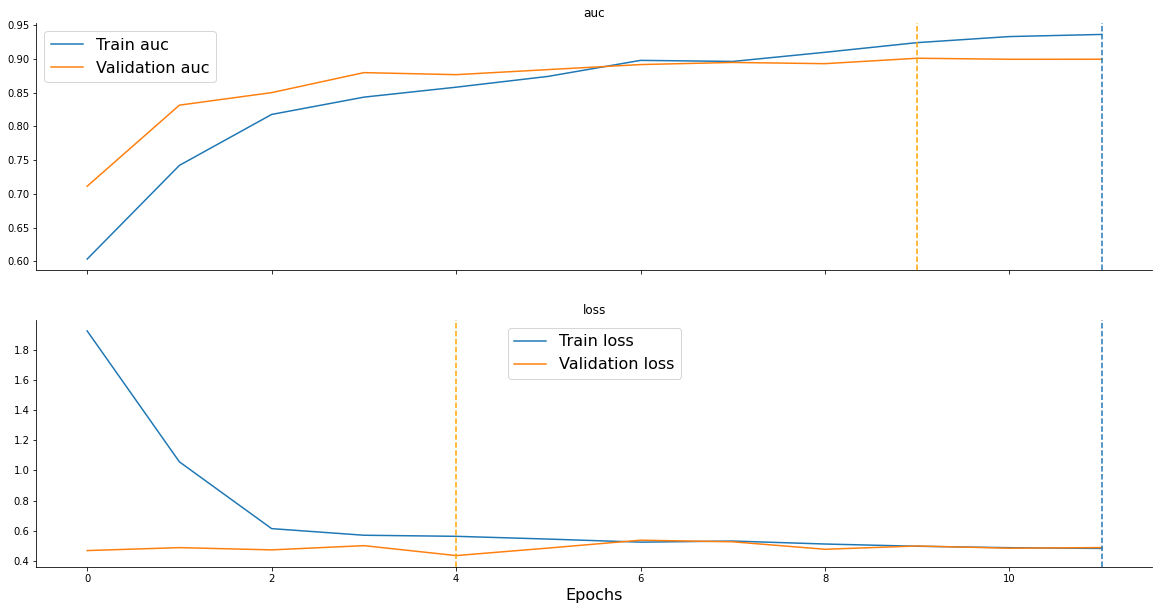

Fold: 2


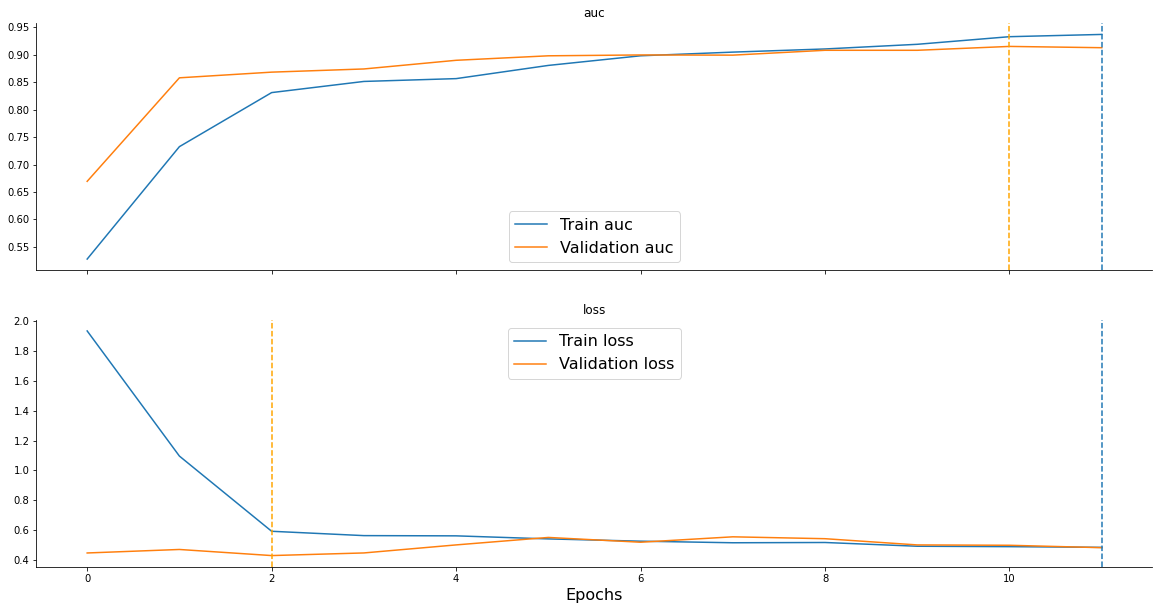

Fold: 3


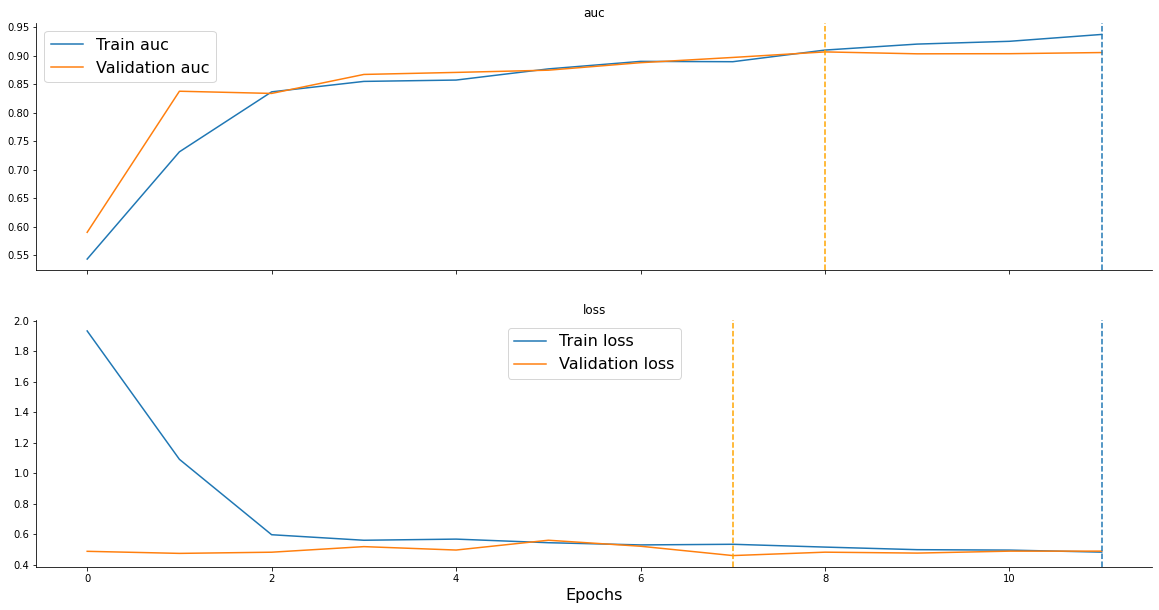

Fold: 4


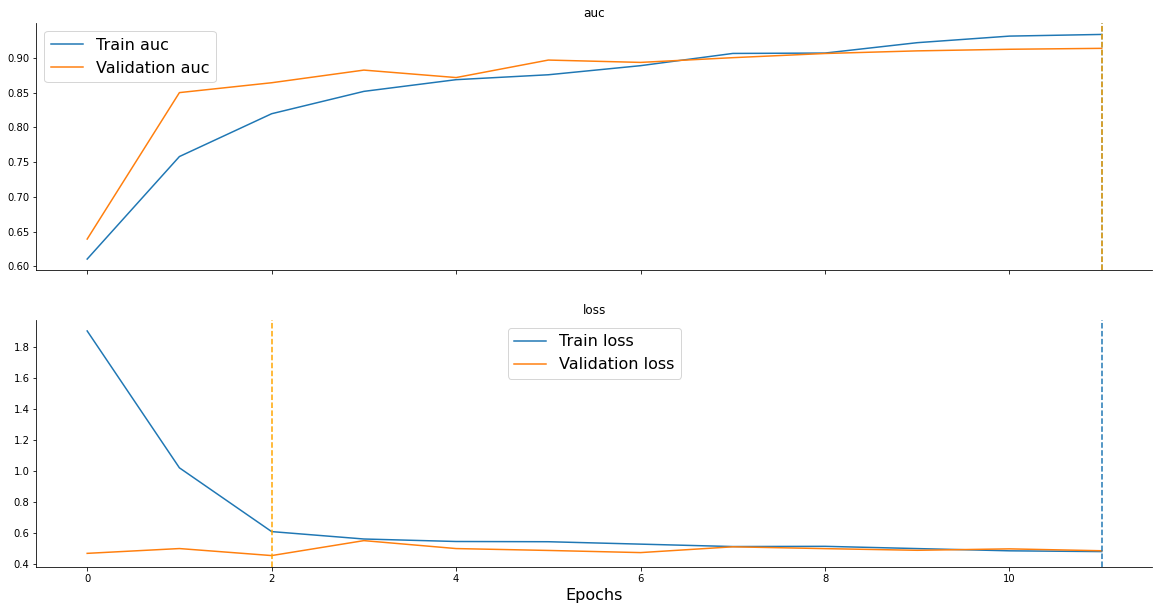

Fold: 5


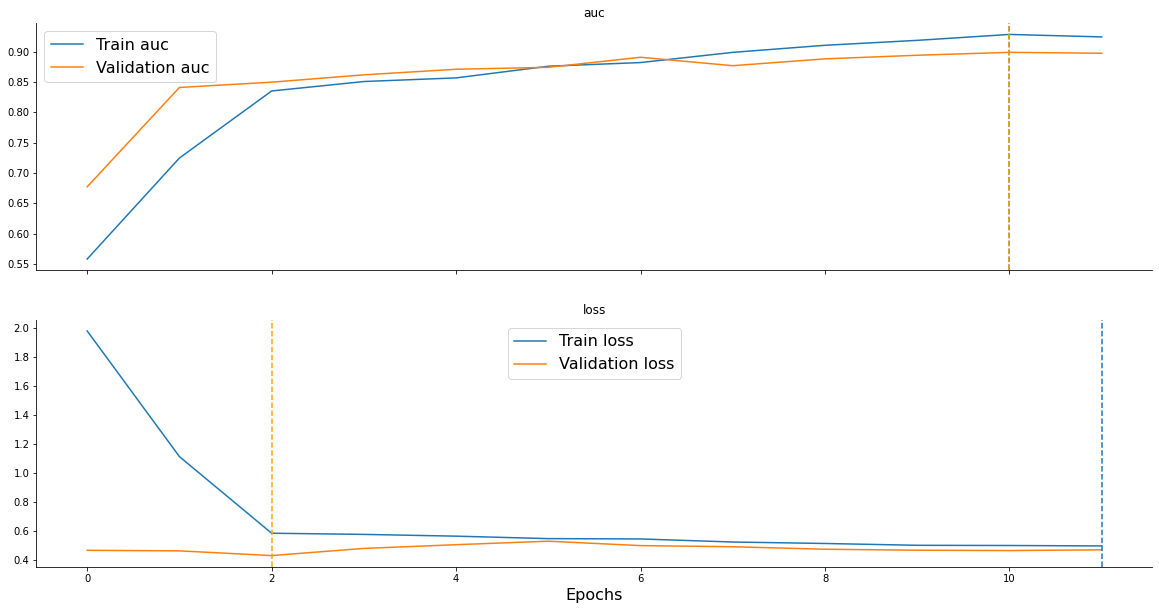

In [15]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

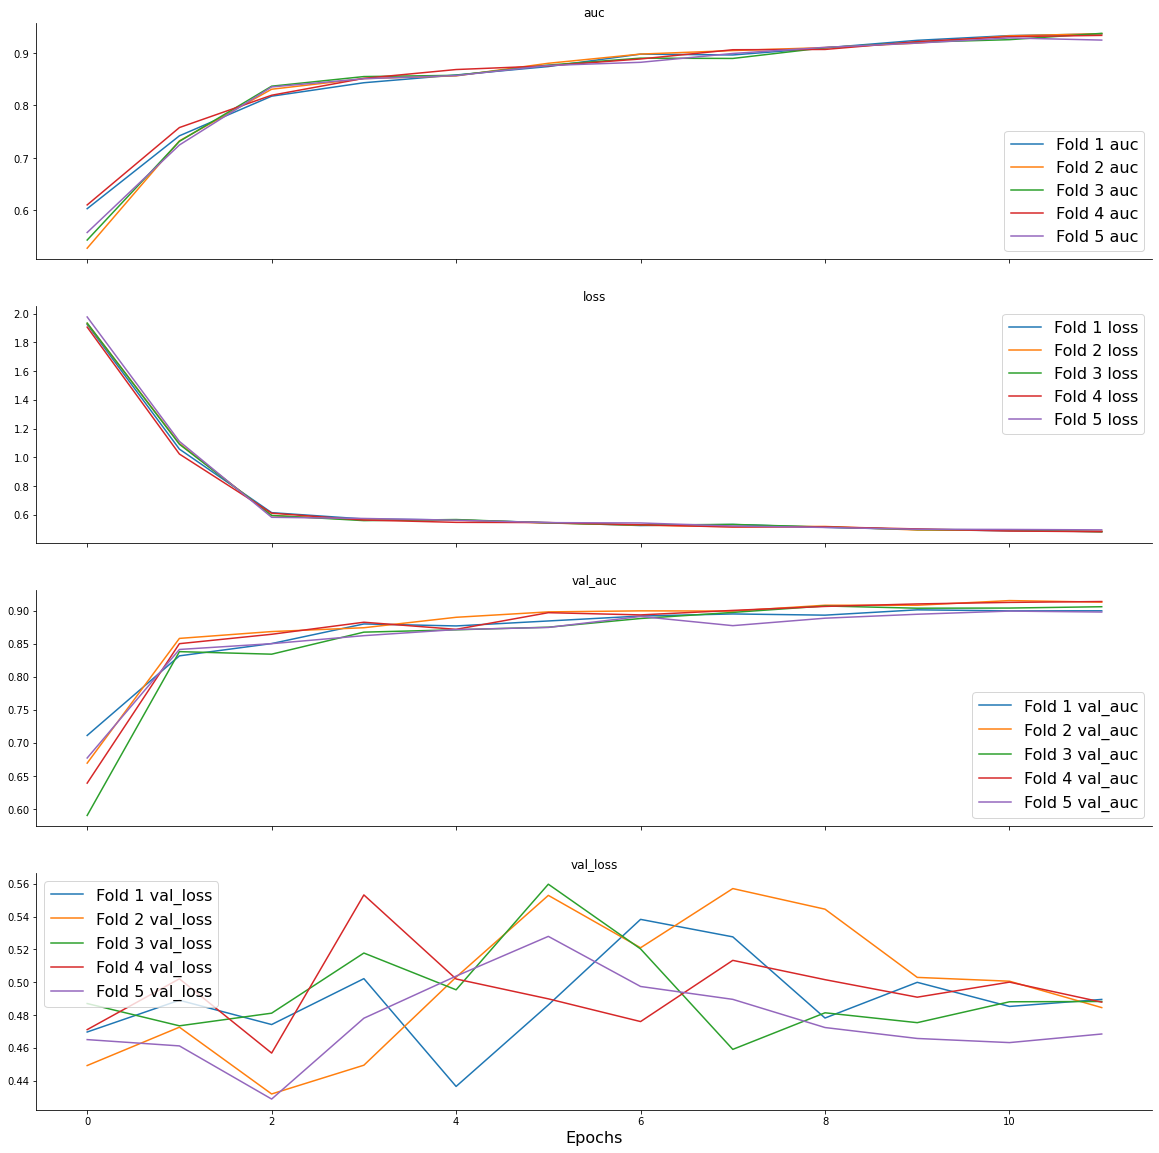

In [16]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [17]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.969065,0.906764,0.062301,0.970111,0.900487,0.971728,0.914602,0.961670,0.906251,0.973090,0.912745,0.968725,0.899734
Accuracy,0.862141,0.855908,0.006233,0.844619,0.848248,0.852482,0.839086,0.869850,0.859454,0.868157,0.856093,0.875598,0.876660
Precision,0.110581,0.088774,0.021807,0.100932,0.084360,0.104565,0.084595,0.113014,0.090631,0.115206,0.091451,0.119191,0.092832
Recall,0.953524,0.764036,0.189488,0.976395,0.773913,0.965591,0.818966,0.924569,0.760684,0.965443,0.779661,0.935622,0.686957
F1-score,0.198070,0.158943,0.039127,0.182951,0.152137,0.188695,0.153349,0.201408,0.161965,0.205848,0.163701,0.211445,0.163561
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.969065,0.906764,0.062301,0.970111,0.900487,0.971728,0.914602,0.961670,0.906251,0.973090,0.912745,0.968725,0.899734
male,0.971301,0.908215,0.063086,0.972861,0.907978,0.974403,0.899430,0.963826,0.896032,0.974220,0.921197,0.971195,0.916436
female,0.964681,0.899982,0.064699,0.965637,0.884015,0.966579,0.931147,0.956966,0.914807,0.970475,0.897522,0.963746,0.872418
head/neck,0.940535,0.848062,0.092474,0.952903,0.772520,0.940282,0.887966,0.924570,0.836982,0.950901,0.862916,0.934020,0.879925
upper extremity,0.969773,0.910356,0.059417,0.973093,0.896246,0.971978,0.917351,0.956436,0.908521,0.973006,0.936516,0.974349,0.893144
lower extremity,0.968830,0.887155,0.081674,0.971961,0.915303,0.967900,0.913242,0.961766,0.879457,0.973215,0.854649,0.969307,0.873125
torso,0.972189,0.922480,0.049709,0.970153,0.916442,0.976330,0.913512,0.967957,0.923825,0.976428,0.941189,0.970078,0.917432
0 <= age < 26,0.956937,0.858048,0.098889,0.955007,1.000000,0.977634,0.834382,0.932456,0.877442,0.962945,0.720588,0.956644,0.857830
26 <= age < 40,0.972383,0.877295,0.095088,0.977658,0.922318,0.971997,0.954910,0.970313,0.847984,0.975478,0.875390,0.966471,0.785875


# Model evaluation (last)

In [18]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.971357,0.905749,0.065609,0.972733,0.899538,0.971259,0.912822,0.970353,0.905164,0.973206,0.913418,0.969235,0.897803
Accuracy,0.864700,0.857545,0.007155,0.854024,0.855438,0.867344,0.854119,0.866560,0.851366,0.866743,0.856399,0.868827,0.870401
Precision,0.112652,0.088644,0.024008,0.106757,0.085828,0.113794,0.088670,0.113694,0.086789,0.114118,0.092445,0.114895,0.089485
Recall,0.960415,0.755341,0.205074,0.976395,0.747826,0.952688,0.775862,0.959052,0.769231,0.965443,0.788136,0.948498,0.695652
F1-score,0.201627,0.158634,0.042994,0.192470,0.153984,0.203304,0.159151,0.203289,0.155979,0.204110,0.165480,0.204962,0.158573
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.971357,0.905749,0.065609,0.972733,0.899538,0.971259,0.912822,0.970353,0.905164,0.973206,0.913418,0.969235,0.897803
male,0.973058,0.905929,0.067130,0.974178,0.902449,0.973387,0.898221,0.971807,0.892990,0.974210,0.921553,0.971711,0.914430
female,0.967800,0.900640,0.067160,0.970169,0.889615,0.966922,0.928664,0.966786,0.915517,0.970799,0.898798,0.964324,0.870607
head/neck,0.944469,0.848756,0.095713,0.953902,0.768392,0.940269,0.884272,0.942278,0.855030,0.951100,0.861998,0.934797,0.874088
upper extremity,0.972090,0.909850,0.062240,0.974670,0.891412,0.971350,0.918210,0.966056,0.913491,0.973295,0.938730,0.975077,0.887405
lower extremity,0.971504,0.885374,0.086130,0.973298,0.913155,0.967590,0.908433,0.973546,0.876198,0.973380,0.856891,0.969707,0.872196
torso,0.974100,0.921168,0.052932,0.974255,0.918383,0.975871,0.912236,0.973450,0.917792,0.976460,0.941152,0.970465,0.916276
0 <= age < 26,0.959837,0.851803,0.108035,0.949279,1.000000,0.978199,0.833333,0.952678,0.861160,0.963321,0.712185,0.955709,0.852335
26 <= age < 40,0.974470,0.881344,0.093126,0.979058,0.930905,0.972603,0.954343,0.977355,0.860282,0.975599,0.878237,0.967733,0.782954


# Confusion matrix

Fold: 1


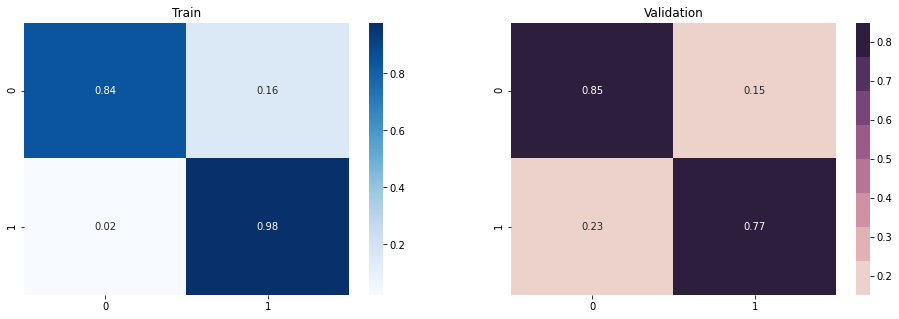

Fold: 2


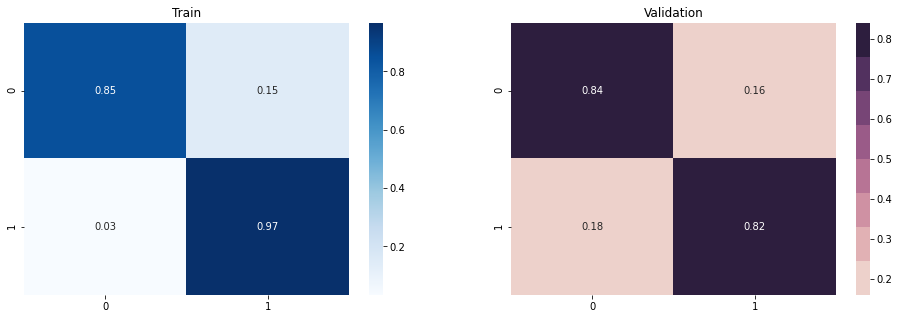

Fold: 3


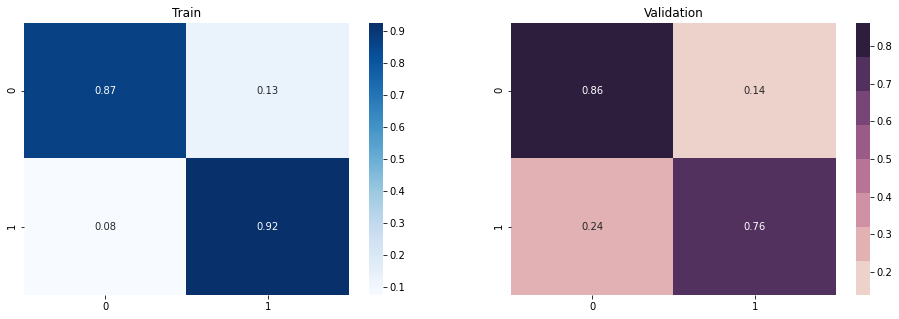

Fold: 4


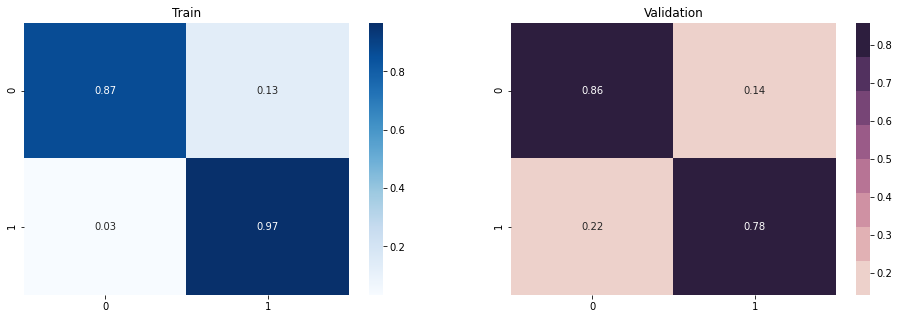

Fold: 5


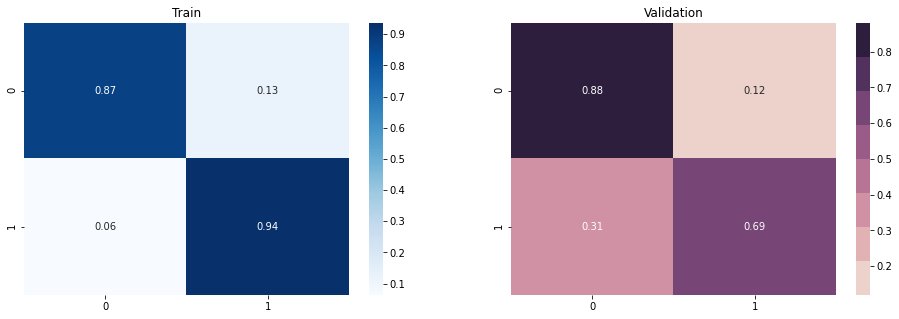

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 4717
Train positive correct predictions: 562
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.452999,0.441365,0.422489,0.492082,0.506511,0.402550
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.058536,0.063285,0.079409,0.047735,0.057879,0.044373
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.066467,0.072268,0.053541,0.052118,0.099383,0.055022
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.280456,0.367519,0.384899,0.160007,0.188918,0.300936
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.045131,0.031580,0.037523,0.070149,0.057744,0.028658
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.095802,0.089261,0.137694,0.109438,0.081545,0.061072
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.129696,0.165631,0.105878,0.096491,0.161527,0.118950
7,ISIC_0075663,female,35.0,torso,unknown,0,0.320518,0.323230,0.394907,0.328814,0.326698,0.228940
8,ISIC_0075914,male,30.0,torso,unknown,0,0.083219,0.087684,0.067159,0.076136,0.085770,0.099345
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.106917,0.068000,0.081846,0.121171,0.105982,0.157585


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.289271,0.637149,0.134097,0.265954,0.159278,0.249875
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.822313,0.830044,0.836314,0.870512,0.869778,0.704915
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.796667,0.930408,0.925383,0.752213,0.520072,0.855258
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.706894,0.655816,0.692494,0.701876,0.795590,0.688694
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.641320,0.691312,0.650340,0.399923,0.601556,0.863471
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.844353,0.823272,0.836812,0.855766,0.810985,0.894927
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.913342,0.975559,0.732286,0.955957,0.950647,0.952260
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.774763,0.847744,0.778139,0.908023,0.779293,0.560619
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.775282,0.895772,0.778708,0.716220,0.806231,0.679480
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.718118,0.846177,0.451716,0.768592,0.880059,0.644048


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.693666,0.657784,0.654572,0.717319,0.719851,0.718804
16,ISIC_0078712,male,40.0,lower extremity,unknown,0,0.521143,0.511569,0.612718,0.444833,0.688476,0.348118
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.601620,0.515088,0.780883,0.632489,0.679084,0.400557
48,ISIC_0092870,male,55.0,torso,unknown,0,0.760499,0.909076,0.806649,0.563287,0.807000,0.716483
65,ISIC_0105145,female,55.0,lower extremity,nevus,0,0.512536,0.652962,0.615387,0.561905,0.336158,0.396269
100,ISIC_0153549,female,45.0,lower extremity,unknown,0,0.504643,0.389008,0.409817,0.400905,0.626854,0.696630
105,ISIC_0154253,male,30.0,torso,unknown,0,0.507128,0.609039,0.429742,0.750239,0.388502,0.358119
111,ISIC_0155012,male,55.0,torso,nevus,0,0.534578,0.589284,0.626588,0.346057,0.621682,0.489278
117,ISIC_0156642,female,40.0,torso,nevus,0,0.501433,0.694479,0.451698,0.547713,0.470155,0.343123
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.741599,0.810522,0.688027,0.784145,0.700101,0.725198


# Visualize test predictions

In [21]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 2076|8906
Test predictions (last) 2016|8966
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.093171,0.100159
1,ISIC_0052349,male,40.0,lower extremity,0.061459,0.064118
2,ISIC_0058510,female,55.0,torso,0.066136,0.066956
3,ISIC_0073313,female,50.0,torso,0.061997,0.069201
4,ISIC_0073502,female,45.0,lower extremity,0.396744,0.368542
5,ISIC_0074618,male,50.0,lower extremity,0.229730,0.230077
6,ISIC_0076801,male,45.0,upper extremity,0.202680,0.194917
7,ISIC_0077586,male,50.0,lower extremity,0.380850,0.356539
8,ISIC_0082004,female,45.0,torso,0.355286,0.341076
9,ISIC_0082785,male,65.0,lower extremity,0.293284,0.282082


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
18,ISIC_0097719,male,45.0,torso,0.598797,0.618505
19,ISIC_0099348,female,45.0,upper extremity,0.590666,0.568885
22,ISIC_0105104,male,40.0,torso,0.597852,0.593824
24,ISIC_0112420,female,65.0,torso,0.864686,0.842072
41,ISIC_0155813,male,55.0,lower extremity,0.621385,0.627216
42,ISIC_0155983,male,70.0,torso,0.892289,0.892862
47,ISIC_0165230,female,35.0,torso,0.505791,0.492480
56,ISIC_0169906,male,85.0,torso,0.754440,0.746591
57,ISIC_0171865,male,65.0,palms/soles,0.810661,0.794565
61,ISIC_0175798,female,55.0,torso,0.725972,0.714653


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
18,ISIC_0097719,male,45.0,torso,0.598797,0.618505
19,ISIC_0099348,female,45.0,upper extremity,0.590666,0.568885
22,ISIC_0105104,male,40.0,torso,0.597852,0.593824
24,ISIC_0112420,female,65.0,torso,0.864686,0.842072
41,ISIC_0155813,male,55.0,lower extremity,0.621385,0.627216
42,ISIC_0155983,male,70.0,torso,0.892289,0.892862
56,ISIC_0169906,male,85.0,torso,0.754440,0.746591
57,ISIC_0171865,male,65.0,palms/soles,0.810661,0.794565
61,ISIC_0175798,female,55.0,torso,0.725972,0.714653
64,ISIC_0178235,female,70.0,lower extremity,0.533443,0.541460


# Test set predictions

In [22]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.093171,0.100159,0.096665
1,ISIC_0052349,0.061459,0.064118,0.062788
2,ISIC_0058510,0.066136,0.066956,0.066546
3,ISIC_0073313,0.061997,0.069201,0.065599
4,ISIC_0073502,0.396744,0.368542,0.382643
5,ISIC_0074618,0.229730,0.230077,0.229904
6,ISIC_0076801,0.202680,0.194917,0.198799
7,ISIC_0077586,0.380850,0.356539,0.368695
8,ISIC_0082004,0.355286,0.341076,0.348181
9,ISIC_0082785,0.293284,0.282082,0.287683


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.280253,0.276088,0.278170
std,0.221938,0.219348,0.220541
min,0.029120,0.030245,0.029683
25%,0.095470,0.095155,0.095457
50%,0.198443,0.193270,0.196046
75%,0.421308,0.413296,0.417445
max,0.975198,0.967221,0.971210
